In [136]:
import yfinance as yf
import pandas as pd
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [137]:
ticker_symbol = 'TATAMOTORS.NS'  
df = yf.download(ticker_symbol, period="10y", interval="1d")
df.to_csv("./data/TATAMOTORS.NS.csv")

[*********************100%***********************]  1 of 1 completed


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2464 entries, 2014-09-22 to 2024-09-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2464 non-null   float64
 1   High       2464 non-null   float64
 2   Low        2464 non-null   float64
 3   Close      2464 non-null   float64
 4   Adj Close  2464 non-null   float64
 5   Volume     2464 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.8 KB


In [139]:
df['Close'].isnull().any()

False

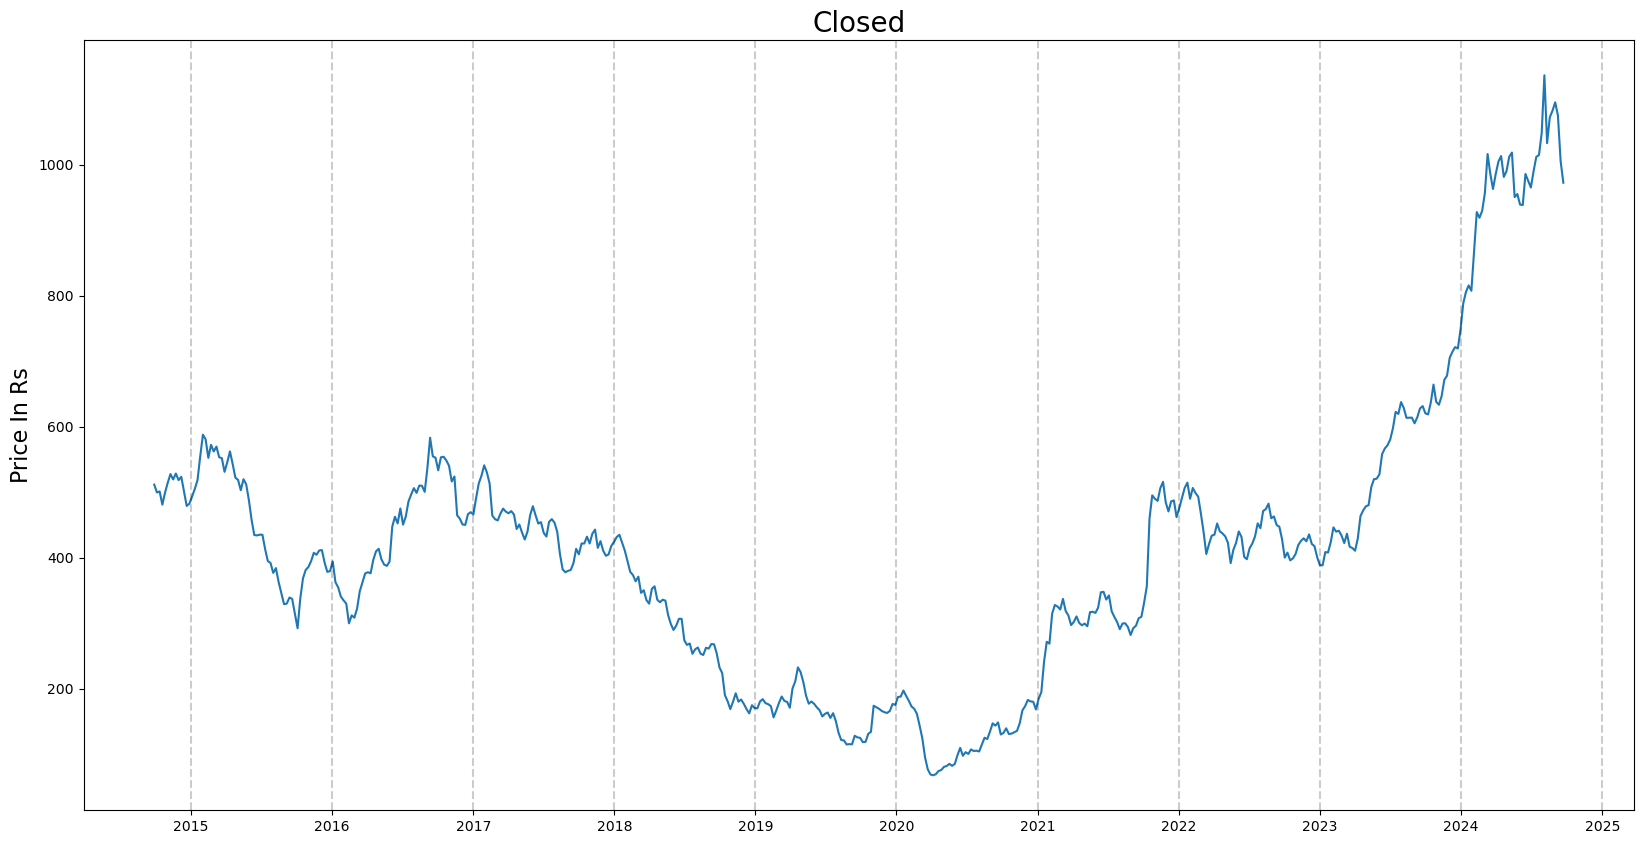

In [140]:
# Plotting the data Grouped by Week

plt.figure(figsize=(20,10))
plt.plot(df['Close'].resample('W').mean())
plt.title('Closed', fontsize=20)
plt.ylabel('Price In Rs', fontsize=16)
for year in range(2015,2026):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [141]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [142]:
# Checking Dickey-Fuller test to find if data is stationary
# h0 -> Null hypothesis - data is not stationary
# h1 -> Alternate Hypothesis

adfuller_test(df.Close)

ADF Test Statistic : -0.05117198418589156
p-value : 0.9540899973304239
#Lags Used : 20
Number of Observations Used : 2443
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Very high p value -> means weak evidence against Null hypothesis 

# Differencing

In [143]:
# taking first difference 

first_diffs = df.Close - df.Close.shift(1)

In [144]:
# Applying transformation to make data statinoary

df['FirstDifference'] = first_diffs
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,FirstDifference
Date,,,,,,,
2014-09-22,509.534729,536.742920,508.545349,534.318909,530.805115,7973384,NaN
2014-09-23,535.951355,536.841858,510.623047,512.304993,508.935974,7528891,-22.013916
2014-09-24,510.524109,512.255554,501.174408,507.951721,504.611328,3887411,-4.353271


In [145]:
df.dropna(inplace=True)

In [146]:
# Checking Dickey-Fuller test to find if data is stationary
# h0 -> Null hypothesis - data is not stationary
# h1 -> Alternate Hypothesis

adfuller_test(df.FirstDifference)


ADF Test Statistic : -9.667096566843538
p-value : 1.306390808950168e-16
#Lags Used : 19
Number of Observations Used : 2443
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\rishi\AppData\Local\Temp\ipykernel_16176\1942575651.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['FirstDifference'].resample('M').mean().plot(legend=True)


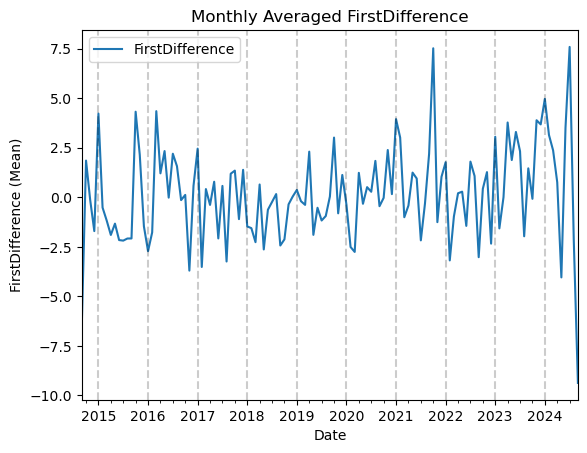

In [147]:
# Plotting Stationary data (grouped by Month)

df['FirstDifference'].resample('M').mean().plot(legend=True)
plt.title('Monthly Averaged FirstDifference')
plt.xlabel('Date')
plt.ylabel('FirstDifference (Mean)')
for year in range(2015,2026):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

# Auto Regressive Model

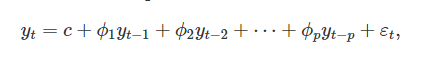

### Final Thoughts on Autocorrelation and Partial Autocorrelation
- Identification of an AR model is often best done with the PACF.

    - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
- Identification of an MA model is often best done with the ACF rather than the PACF. p,d,q

    - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
- p AR model lags d differencing q MA lags

In [149]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm


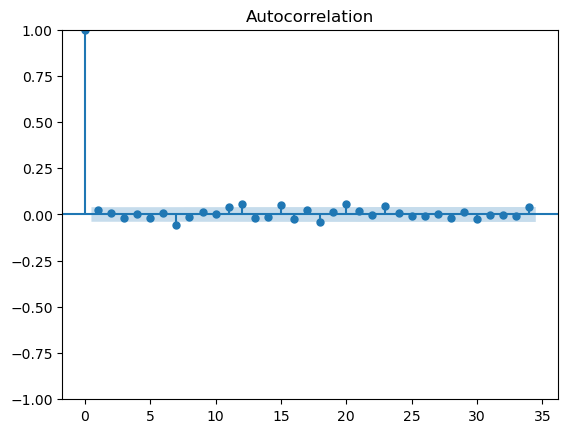

In [190]:
# Plotting ACF plot to choose value for MA 

plot_acf(df.FirstDifference)
plt.show()

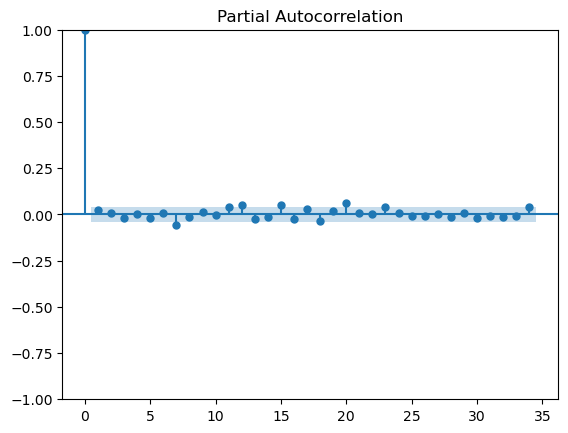

In [191]:
# Plotting PACF plot to choose value for AR

plot_pacf(df.FirstDifference)
plt.show()

In [192]:
# Creating the ARIMA model and fitting the values

model = ARIMA(df.FirstDifference.dropna(), order=(1,1,0))
result = model.fit()

c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [193]:
# Summary for ARIMA model

fvalues = result.fittedvalues
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        FirstDifference   No. Observations:                 2463
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9595.484
Date:                Sun, 22 Sep 2024   AIC                          19194.967
Time:                        17:31:25   BIC                          19206.585
Sample:                             0   HQIC                         19199.188
                               - 2463                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4900      0.010    -47.765      0.000      -0.510      -0.470
sigma2       142.1127      2.116     67.174      0.000     137.966     146.259
===================================================================================
Ljung-Box (L1) (Q):                  56.90   Jarque-Bera (JB):              3011.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

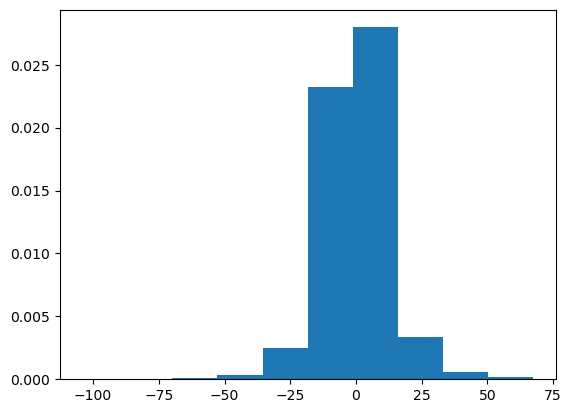

In [194]:
# Plotting residual plot

residual = result.resid
plt.hist(residual, density=True)
plt.show()

[]

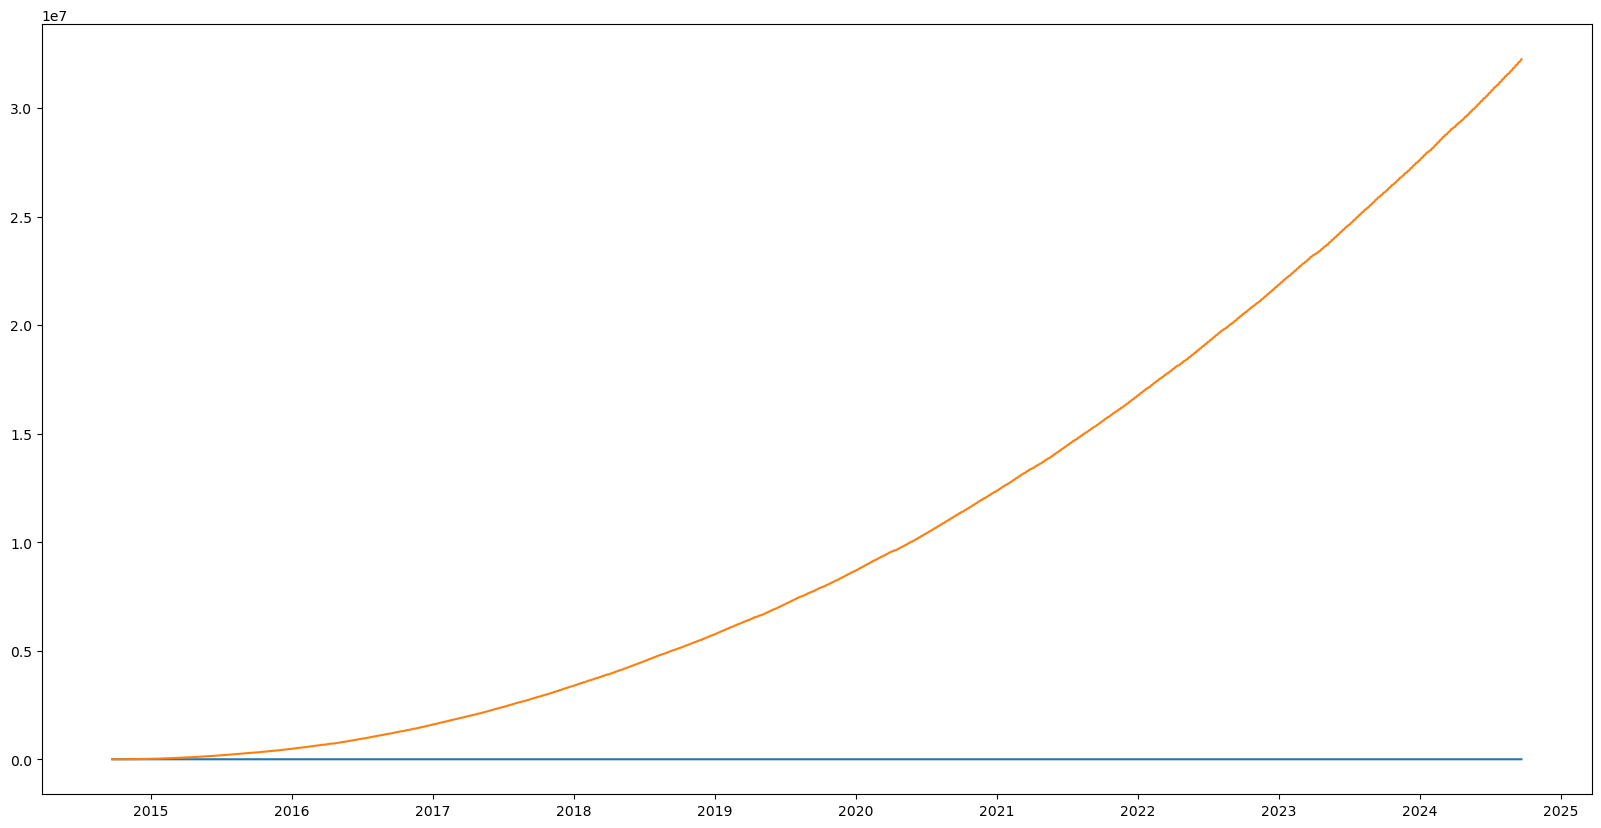

In [197]:
# Plotting the transformed fitted value 

residual = residual.cumsum()
plt.figure(figsize=(20,10))
plt.plot(df.FirstDifference[:])
plt.plot(residual[:])
plt.plot()

In [200]:
# Inversing the transformation to get original data back

a = df.Close - df.FirstDifference
diff_results = residual + residual.shift(-1)
diff_results = diff_results + a

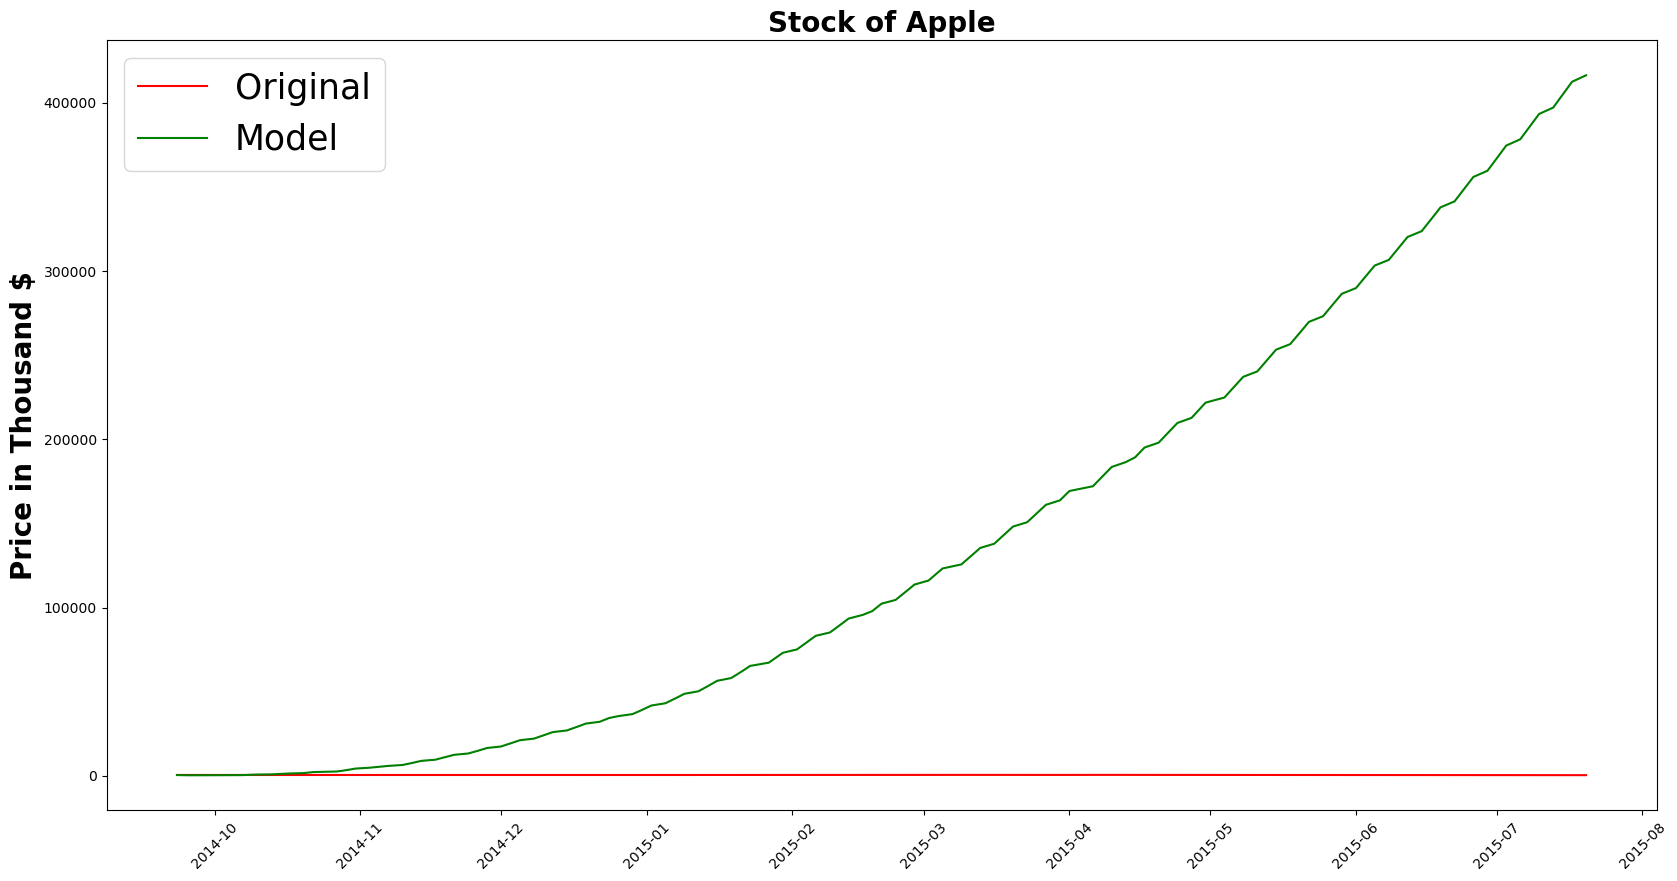

In [202]:
# Plotting the original fitted value

plt.figure(figsize=(20,10))
plt.plot(df.iloc[:200].Close, label='Original', color='red')
plt.plot(diff_results[:200], label='Model', color='green')
plt.title('Stock of Apple', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

<Axes: xlabel='Date'>

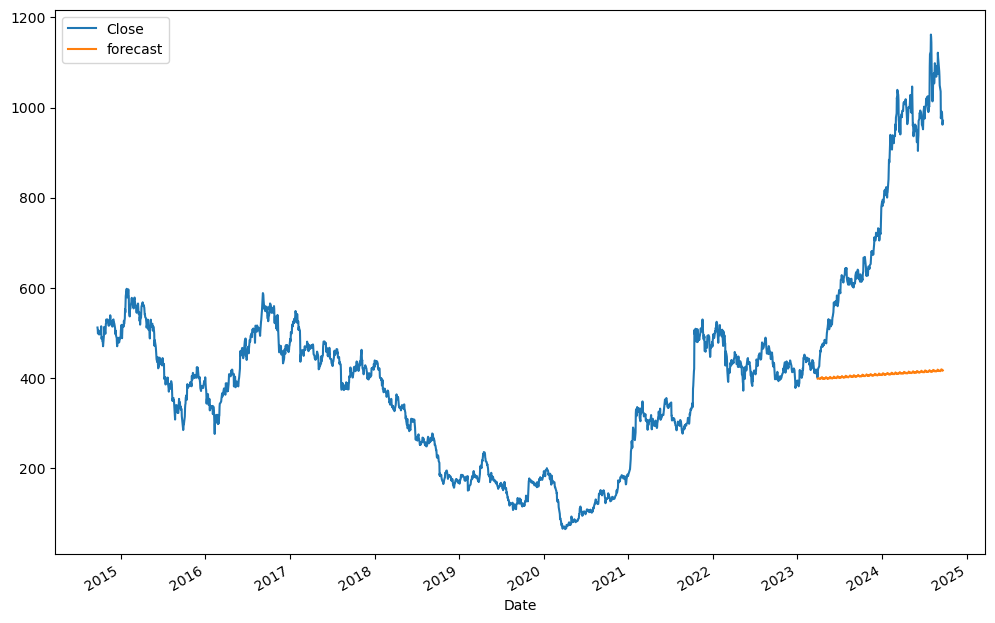

In [156]:
df['forecast']=results.predict(start=2100,end=2461,dynamic=True)
df[['Close','forecast']].plot(figsize=(12,8))

In [163]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,100)]

In [164]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)


In [165]:
future_datest_df.tail()


,Open,High,Low,Close,Adj Close,Volume,FirstDifference,forecast
2032-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
future_df=pd.concat([df,future_datest_df])


C:\Users\rishi\AppData\Local\Temp\ipykernel_16176\1188595892.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_datest_df])


c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

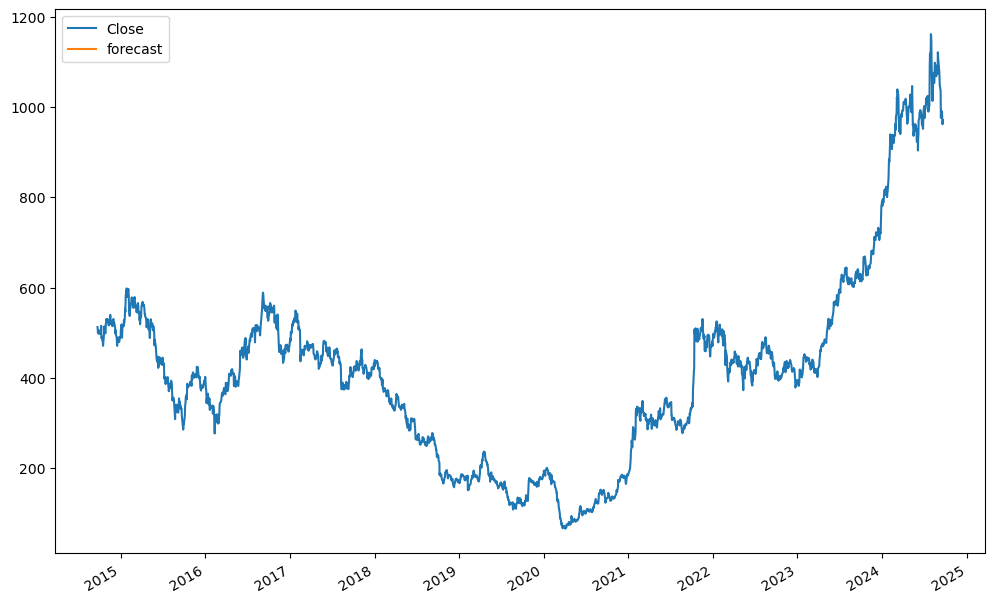

In [179]:
future_df['forecast']=results.predict(start=2462,end=2560,dynamic=True)
future_df[['Close','forecast']].plot(figsize=(12,8))

In [183]:
future_df.shape

(2562, 8)

In [184]:
future_df.tail()

,Open,High,Low,Close,Adj Close,Volume,FirstDifference,forecast
2032-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
